# Exploratory Data Analysis 
> Prototyping D: Code Completion

Heatmaps illustrate the strength of the dependencies between the generated code and the computed rationales. Rationales and target tokens are categorized according to their respective types. This notebook presents three experiments designed to reveal these dependencies at different levels of granularity:
- **Level 1**: Rationales and target tokens are grouped according to the initial taxonomy defined in our paper.
- **Level 2**: Rationales and target tokens are categorized based on the type of information they convey, which can be either semantic or non-semantic, from both natural language and source code.

Experiments [1.4.1] and [1.4.2] focus on examining these dependencies by creating heatmaps for Level 1 and Level 2 clusterings. Experiment [1.4.3] explores the integration of both clustering levels.

*Notebook Structure*
- Notebook parameters
- Source Code
    - Imports
    - Dictionary Flatting
    - Statistics 
    - Data processing
    - Grouping storing
    - Groupings
    - Visualization
    - Countings
    - Bootstrapping probability
    - Calculate statistics and get results DF
    - Create Groupings
- Experiment [1.4.1]
- Experiment [1.4.2]
- Experiment [1.4.3]
- Experiment [1.4.3]

*General Instructions*
* Collapse cells by tittle to improve the navigation
* Before running the experiments, it is required to have global_taxonomy_results with the level_0 aggragation reuslts of each dataset.
* Read description on each experiment for further instructions

In [1]:
def param_default():
    return {
        'model': 'codeparrot', ### Model name
        'dataset' : 'DC_SG_BD', #### Full list in datasets
        'modality' : 'sc', #### [sc]: source code, [nl_sc]: natural language and source code
        'datasets' : {
            'SG_BD' : 'code_completion_random_cut_5k_30_512_tokens', 
            'DC_SG_BD' : 'code_completion_docstring_random_cut_3.8k_30_150_tokens', 
            'DC_SG' : 'code_completion_docstring_signature_3.8k_30_150_tokens', 
            'DC': 'code_completion_docstring_5k_30_150_tokens'
        },
        'num_experiments' : 30, 
        'bootstrapping_size': 500,
        ################ INPUT DATA
        'global_taxonomy_results': '/workspaces/code-rationales/data/global_taxonomy_results',
        ################ OUTPUT DATA
        'plot_values_results' : '/workspaces/code-rationales/data/experiments/plot_values_results',
        'grouping_results' : '/workspaces/code-rationales/data/experiments/grouping_results', 
    }
params = param_default()

## Source Code

### Imports

In [2]:
import json
import pandas as pd
import numpy as np
import math
from statistics import NormalDist

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

pd.options.display.float_format = '{:.2f}'.format

In [3]:
from code_rationales.taxonomies import *
import os.path

### Dictionary Flatting

In [4]:
def flat_global_results(experiment_global_result: dict):
    flatten_results = { key: [] for key in experiment_global_result.keys() }
    for target_key, rationales in experiment_global_result.items():
        for rational_key, rational_values in rationales.items():
            flatten_results[rational_key] += rational_values
    return flatten_results

### Statistics

In [5]:
def bootstrapping( np_data, np_func, size ):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #Cleaning NaNs
    #np_data_clean = np_data[ np.logical_not( np.isnan(np_data) ) ] 
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    #This strategy might work as imputation 
    bootstrap_repl = [ np_func( np.random.choice( np_data, size=len(np_data) ) ) for i in range( size ) ]
    
    #logging.info("Covariate: " + cov) #Empirical Mean
    #logging.info("Empirical Mean: " + str(np.mean(np_data_clean))) #Empirical Mean
    #logging.info("Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return np.array( bootstrap_repl )

In [6]:
def confidence_intervals_large_samples(data, confidence=0.95):
    """
    @confidence: confidence interval 
    @return: tuple (lowerbound, uperbound, h-value)
    """
    dist = NormalDist.from_samples( data )
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h, h

In [7]:
def boostrap_dictionary(dictionary: dict, size):
    boostrapped_dict = {}
    for key, values in dictionary.items():
        if values:
            boostrapped_dict[key] = bootstrapping(values, np.mean, size)
    return boostrapped_dict

### Data processing


In [8]:
def clean_results(global_results):
    def clean_dictonary(result_dict):
        clean_dict = result_dict.copy()
        for key, value in result_dict.items():
            if not value:
                clean_dict.pop(key)
        return clean_dict
    for key, value in global_results.items():
        global_results[key] = clean_dictonary(value)
    return clean_dictonary(global_results)

In [9]:
def get_experiments_dfs(experients_global_results):
    experiment_dfs = []
    for experiment in experients_global_results:
        experiment = flat_global_results(experiment)
        experiment = boostrap_dictionary(dictionary=experiment, size=params['bootstrapping_size'])
        experiment_dfs.append(pd.DataFrame(experiment))
    return experiment_dfs

In [10]:
### REDUCE EXPERIMENTS FOR HEATMAPS
def reduce_rationales_df(experients_global_results: dict, target_list: list, source_list: list):
    reduced_rationales_df = {target: {rational: [] for rational in source_list} for target in target_list}
    for experient_global_result in experients_global_results:
        target_dictionary = {key: value for key, value in experient_global_result.items() if key in target_list}
        for target_key in target_dictionary.keys():
            target_dictionary[target_key] = {key: np.median(bootstrapping(value, np.mean, 100)) # MEDIAN FOR EXPERIMENT RESULT
                                             for key, value in target_dictionary[target_key].items() if key in source_list}
            for rational_key in target_dictionary[target_key].keys():
                reduced_rationales_df[target_key][rational_key].append(target_dictionary[target_key][rational_key])
    for target_key in reduced_rationales_df.keys():
        reduced_rationales_df[target_key] = boostrap_dictionary(reduced_rationales_df[target_key], 100)
    return reduced_rationales_df         

In [11]:
def create_data_to_plot(experients_global_results, target_list, source_list, name):
    file_path = params['plot_values_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][params['dataset']] + '___' + name + '.csv'
    if os.path.isfile(file_path):
          reduced_df = pd.read_csv(file_path, index_col=[0])
          return reduced_df
    reduced_rationales_global_results_df = pd.DataFrame(reduce_rationales_df(experients_global_results, target_list, source_list)).fillna(0)
    for column in reduced_rationales_global_results_df.columns:
            reduced_rationales_global_results_df[column] = reduced_rationales_global_results_df[column].apply(lambda value: np.median(value))
    reduced_rationales_global_results_df.to_csv(file_path)
    return reduced_rationales_global_results_df

### Grouping Storing

In [12]:
def store_groupings(global_results: list, path:str):
    with open(path, 'w') as output_file: 
        json.dump(global_results, output_file)

In [13]:
def open_groupings(path:str):
    with open(path, 'r') as output_file:
        data = json.load(output_file)
    return data

### Grouping

In [14]:
get_experiment_path =  lambda results_folder, dataset, exp: results_folder + '/' + dataset + '_exp_' + str(exp) +'.txt'

In [15]:
def get_experiments_results(results_folder, name:str):
    file_path = params['grouping_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][params['dataset']] + '_' + name + '.json'
    if os.path.isfile(file_path):
        return open_groupings(file_path)
    experiment_paths = [get_experiment_path(results_folder + '/' + params['model'] + '/' + params['modality'], params['datasets'][params['dataset']], exp) for exp in range(params['num_experiments'])]
    experiment_global_results = []
    for experiment_path in experiment_paths:
        with open(experiment_path, 'r') as file:
            experiment_global_results.append(json.loads(file.read()))
    store_groupings(experiment_global_results, file_path)
    return experiment_global_results

In [16]:
def get_global_results_category_by_groups(experients_global_results: list, name: str):
    file_path = params['grouping_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][params['dataset']] + '_' + name + '.json'
    if os.path.isfile(file_path):
        return open_groupings(file_path)
    global_results_by_groups = [{} for _ in range(len(experients_global_results))]
    for exp_id, experiment_result in enumerate(experients_global_results):
        experiment = {category: {group: [] for group in global_groups().keys()} for category in experiment_result.keys()}
        for target_category in experiment_result.keys():
            for rational_category, rational_values in experiment_result[target_category].items():
                experiment[target_category][list(filter(lambda group: rational_category in global_groups()[group], global_groups().keys()))[0]] += rational_values
    for exp_id, experiment_result in enumerate(experients_global_results):
        global_results_by_groups[exp_id] = clean_results(experiment)
    store_groupings(global_results_by_groups, file_path)
    return global_results_by_groups

In [17]:
def get_global_results_group_by_categories(experients_global_results: list, name: str):
    file_path = params['grouping_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][params['dataset']] + '_' + name + '.json'
    if os.path.isfile(file_path):
        return open_groupings(file_path)
    global_results_by_groups = [{} for _ in range(len(experients_global_results))]
    for exp_id, experiment_result in enumerate(experients_global_results):
        experiment = {group: {category: [] for category in experiment_result.keys()} for group in global_groups().keys()}
        for target_category in experiment_result.keys():
            for rational_category, rational_values in experiment_result[target_category].items():
                experiment[list(filter(lambda group: target_category in global_groups()[group], global_groups().keys()))[0]][rational_category] += rational_values
    for exp_id, experiment_result in enumerate(experients_global_results):
        global_results_by_groups[exp_id] = clean_results(experiment)
    store_groupings(global_results_by_groups, file_path)
    return global_results_by_groups

In [18]:
def get_global_results_group_by_groups(experients_global_results: list, name: str): 
    file_path = params['grouping_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][params['dataset']] + '_' + name + '.json'
    if os.path.isfile(file_path):
        return open_groupings(file_path)
    global_results_by_groups = [{} for _ in range(len(experients_global_results))]
    for exp_id, experiment_result in enumerate(experients_global_results):
        experiment = {group_target: {group_rational: [] for group_rational in global_groups().keys()} for group_target in global_groups().keys()}
        for target_category in experiment_result.keys():
            for rational_category, rational_values in experiment_result[target_category].items():
                experiment[list(filter(lambda group: target_category in global_groups()[group], global_groups().keys()))[0]][list(filter(lambda group: rational_category in global_groups()[group], global_groups().keys()))[0]] += rational_values
    for exp_id, experiment_result in enumerate(experients_global_results):
        global_results_by_groups[exp_id] = clean_results(experiment)
    store_groupings(global_results_by_groups, file_path)
    return global_results_by_groups

In [19]:
def get_reduced_rationales_results(name, experiments_results: dict, target_list: list, source_list: list,):
    reduced_rationales_global_results_df = create_data_to_plot(experiments_results, target_list, source_list, name)
    reduced_rationales_global_results_df = reduced_rationales_global_results_df.sort_index().sort_index(axis=1)
    return reduced_rationales_global_results_df

### Visualization

In [20]:
def print_heatmap(
        reduced_rationales_global_results_df,
        ylabel: str, 
        xlabel: str,
        fig_size = (10,10), 
        font = 20, 
        vmax = 0.22
):        
        #cmap = LinearSegmentedColormap.from_list('custom_map', ['black','green'], N=128)
        #cmap = "YlGnBu"

        plt.rcParams.update({'font.size': font})
        ax = plt.axes()
        sns.set(rc = {'figure.figsize':fig_size})
        sns.heatmap(reduced_rationales_global_results_df, 
                    #cmap=cmap, 
                    vmin=0, vmax=vmax,
                    ax=ax)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show
        pass

### Countings

In [21]:
def create_frequencies_dataframe(experients_global_results: list):
    frequencies_df = pd.DataFrame(columns=experients_global_results[0].keys())
    for experiment_global_result in experients_global_results:
        rationales_results = flat_global_results(experiment_global_result)
        frequencies_df = frequencies_df.append({key: len(value) for key, value in rationales_results.items()}, ignore_index=True)
    frequencies_df = frequencies_df.fillna(0)   
    return frequencies_df


### Bootstrapping probability

In [22]:
# Function to fill NaN values with random chose from a specified array
def fill_nan_with_random_col(col):
    if col.isna().sum() == 0:
        return col
    random_values = np.random.choice(col[col.notna()].to_list(), col.isna().sum())
    col[col.isna()] = random_values
    return col

In [23]:
def create_bootstapped_dataframe(experients_global_results:list):
    bootstrapped_df = pd.DataFrame(columns=experients_global_results[0].keys())
    for experiment_global_result in experients_global_results:
        rationales_results = flat_global_results(experiment_global_result)
        rationales_results = boostrap_dictionary(dictionary=rationales_results, size=params['bootstrapping_size'])
        bootstrapped_df = bootstrapped_df.append({key: np.median(value) for key, value in rationales_results.items()}, ignore_index=True)
    return bootstrapped_df

### Calculate statistics and get results DF

In [24]:
### CREATE GROUP FREQUENCY RESULTS
def calculate_results(global_dataframe):
    results_df = pd.DataFrame(columns=['type', 'group', 'category', 'mean', 'median', 'std', 'ci'])
    for category in global_dataframe.columns:
        experiments_values = global_dataframe[category].tolist()
        try:
            group = [key for key, value in global_groups().items() if category in value][0] ## Mapping from taxonomy groups
        except Exception as e:
            print(e)
        results_df = results_df.append({
            'type': group.split('_')[0], 
            'group': group, 
            'category': category, 
            'median' : np.median(experiments_values),
            'mean' : np.mean(experiments_values), 
            'std' : np.std(experiments_values),
            'ci' : confidence_intervals_large_samples(experiments_values)
        }, ignore_index=True)
    return results_df.sort_values(by='median', ascending=False).reset_index(drop=True)

## Experiment [1.4.1]
**Level 1 heatmap dependency for the 4 types of prompts**

*Sub-research Question: How strong are the dependencies between source and target elements when aggregated by level 1*

General Instructions: Execute this experiment per dataset separately
- Change ```dataset``` in ```param_default```, indicating the id of the dataset.
- Change ```modality``` in ```param_default```, indicating the id of the modality in the prompt
- Change ```model``` in ```param_default```, indicating the name of the model used for inference

### Prototyping Methodology
Here we expose the step by step to run this experiment.

#### Step 1: Define list of target and rationales elements

In [26]:
##### TARGET - CATEGORY ALL
##### SOURCE - CATEGORY ALL
target_elements = [category for categories in global_groups().values() for category in categories] #X
source_elements = [category for categories in global_groups().values() for category in categories] #Y

#### Step 2: Obtain aggregated results
- retrieves a list of 30 dictionaries with level_0 global aggregation results for the current dataset. Each dictionary correspond to the result of one execution
- merges the information of all 30 dictionaries into a single dictionary by flatting the values after grouping by the specified list of source and target categories. statistical bootstrapping is applied to ensure a minimun of 100 values per target and rational in the resulting dictionary with lower dimentionality.
- reduces the resulting dictionary into a two dimentional matrix (dataframe) where each row correspond to a target and each column to a rational, by calculating the median of collected rationales values per target. 

In [27]:
experiments_global_results = get_experiments_results(params['global_taxonomy_results'], 'level_1')
rationales_results = get_reduced_rationales_results('level_1', experiments_global_results, target_list=target_elements, source_list=source_elements)

#### Step 3: Print the Heatmap

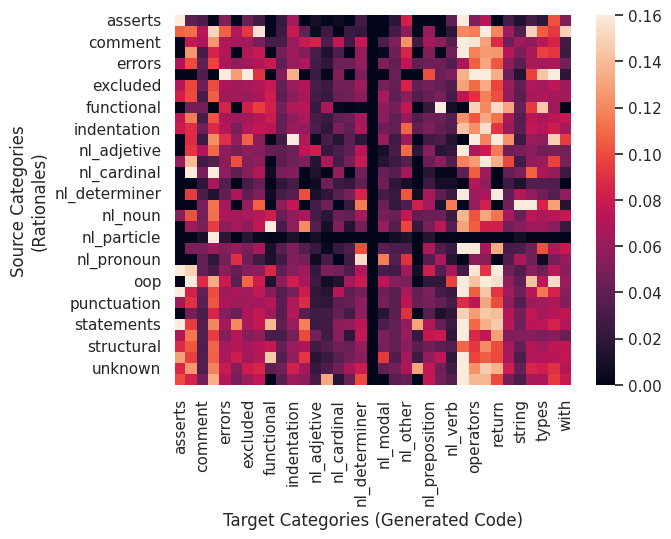

In [28]:
print_heatmap(rationales_results, xlabel='Target Categories (Generated Code)', ylabel='Source Categories\n(Rationales)', fig_size=(10,10), font=10, vmax=0.16)

### Prototyping results
The following subsections show the generated *level_1* heatmaps for all the four datasets, in the two modalitites. 
To generate the plots from scrach, please modify the following parameters in ```param_default``` at the beginning of the notebook and run the notebook until this point. 
- ```'model'```
- ```'dataset'```
- ```'modality'```

### Results
* Heapmaps for [SC + BD] in both modalities are the same. In both cases the samples are treated as source code since they only include the signature and part of the body.
* Aggregated rationales probabilites were very low. the highest value reported in the heatmaps is 0.16
* [nl_list] was the target element with the lowest rationales probabilities across all datasets. We believe this is because the frequency of that type in the dataset is very low. later confirmed by the results in RQ[1.4.0.1]
* [bool, oop, operators, punctuation, return] were the target elements with the highest rationales probabilities across all datasets. 
* [nl_particle] was the type of rational that influenced the least to the generation of elements in all datasets. 


##### Modality SC
![level_1.png](captures/heatmaps/sc/level_1.jpg)

##### Modality NL_SC
![level_1.png](captures/heatmaps/nl_sc/level_1.jpg)

## Experiment [1.4.2]
**Level 2 heatmap dependency for the 4 types of prompts**

*Sub-research Question: How strong are the dependencies between source and target elements when aggregated by level 2*

General Instructions: Execute this experiment per dataset separately
- Change ```dataset``` in ```param_default```, indicating the id of the dataset.
- Change ```modality``` in ```param_default```, indicating the id of the modality in the prompt
- Change ```model``` in ```param_default```, indicating the name of the model used for inference

### Prototyping Methodology
Here we expose the step by step to run this experiment.

#### Step 1: Define list of target and rationales elements

In [29]:
##### TARGET - GROUP 
##### SOURCE - GROUP
target_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #X
source_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #Y

#### Step 2: Obtain aggregated results
- retrieves a list of 30 dictionaries with level_0 global aggregation results for the current dataset. Each dictionary correspond to the result of one execution
- merges the information of all 30 dictionaries into a single dictionary by flatting the values after grouping by the specified list of source and target categories. statistical bootstrapping is applied to ensure a minimun of 100 values per target and rational in the resulting dictionary with lower dimentionality.
- reduces the resulting dictionary into a two dimentional matrix (dataframe) where each row correspond to a target and each column to a rational, by calculating the median of collected rationales values per target. 

In [30]:
global_results_groups_by_groups = get_global_results_group_by_groups(experiments_global_results, 'level_2')
rationales_results = get_reduced_rationales_results('level_2', global_results_groups_by_groups, target_list=target_elements, source_list=source_elements)

#### Step 3: Print the Heatmap

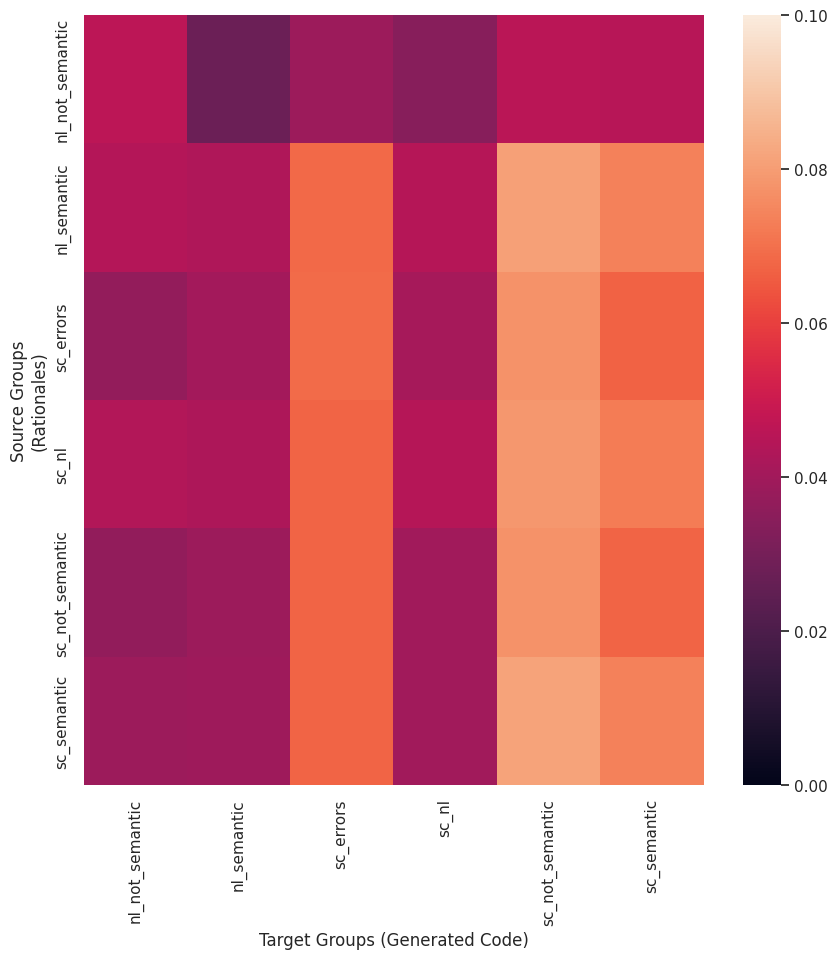

In [31]:
print_heatmap(rationales_results, xlabel='Target Groups (Generated Code)', ylabel='Source Groups\n(Rationales)', fig_size=(15,5), vmax=0.1)

### Prototyping results
The following subsections show the generated *level_2* heatmaps for all the four datasets, in the two modalitites. 
To generate the plots from scrach, please modify the following parameters in ```param_default``` at the beginning of the notebook and run the notebook until this point. 
- ```'model'```
- ```'dataset'```
- ```'modality'```

### Results
- Semantic elements in the source code appear to be generated by all types of elements, except for non-semantic in natural language.
- Natural language elements within the source code, as natural language, appear to have not dependencies with any other types of elements. We attribute this to the specific nature of the model used (CodeParrot), which was exclusively trained to predict source code. 
- In all datasets, elements associated with syntax errors in the source code generate both semantic and non-semantic elements.


#### Modality SC
![level_2.png](captures/heatmaps/nl_sc/level_2.jpg)

#### Modality NL_SC
![level_2.png](captures/heatmaps/sc/level_2.jpg)

## Experiment [1.4.3]
**Level 2(rationales) 1(target) heatmap dependency for the 4 types of prompts**

*Sub-research Question: How strong are the dependencies between source and target elements when aggregated by level 2 and level 1 respectively*

General Instructions: Execute this experiment per dataset separately
- Change ```dataset``` in ```param_default```, indicating the id of the dataset.
- Change ```modality``` in ```param_default```, indicating the id of the modality in the prompt
- Change ```model``` in ```param_default```, indicating the name of the model used for inference

### Prototyping Methodology
Here we expose the step by step to run this experiment.

#### Step 1: Define list of target and rationales elements

In [32]:
##### TARGET - CATEGORY 
##### SOURCE - GROUP
target_elements = [category for categories in global_groups().values() for category in categories] #X
source_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #Y

#### Step 2: Obtain aggregated results
- retrieves a list of 30 dictionaries with level_0 global aggregation results for the current dataset. Each dictionary correspond to the result of one execution
- merges the information of all 30 dictionaries into a single dictionary by flatting the values after grouping by the specified list of source and target categories. statistical bootstrapping is applied to ensure a minimun of 100 values per target and rational in the resulting dictionary with lower dimentionality.
- reduces the resulting dictionary into a two dimentional matrix (dataframe) where each row correspond to a target and each column to a rational, by calculating the median of collected rationales values per target. 

In [33]:
global_results_category_by_groups = get_global_results_category_by_groups(experiments_global_results, 'level_2_1')
rationales_results = get_reduced_rationales_results('level_2_1', global_results_category_by_groups, target_list=target_elements, source_list=source_elements)

#### Step 3: Print the Heatmap

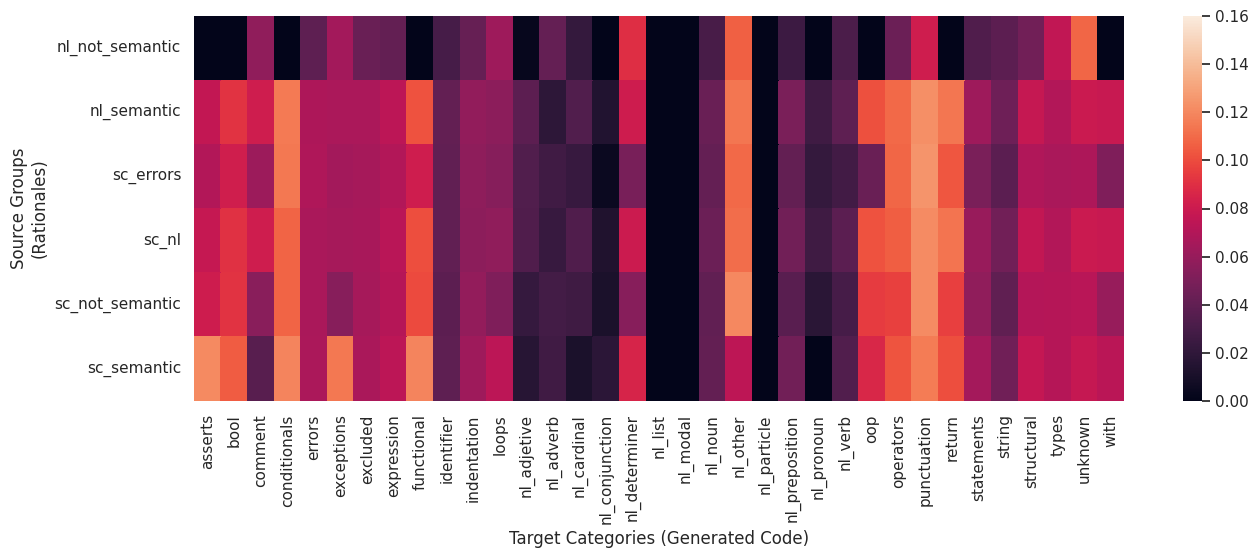

In [34]:
print_heatmap(rationales_results, xlabel='Target Categories (Generated Code)', ylabel='Source Groups\n(Rationales)', fig_size=(20,5), font=10 ,vmax=0.16)

### Prototyping results
The following subsections show the generated *level_2_1* heatmaps for all the four datasets, in the two modalitites. 
To generate the plots from scrach, please modify the following parameters in ```param_default``` at the beginning of the notebook and run the notebook until this point. 
- ```'model'```
- ```'dataset'```
- ```'modality'```

### Results
- [punctuation] elements are generated with a higher probability than other types.
- [nl_list] elements are generated with very low probabilities than any other type. 
- [oop] elements are generated with different probabilities in the four datasets. for [DC + SG] and [DC + SG + BD], syntax errors and source code non semantic elements have the highest probability to generate [oop] elements. This could indicate a problem of overinterpretation with coparrot, since the model is predicting from errors and non semantic information. 
- In the [DC] dataset, [bool] elements are predicted by semantic elements in both language and source code, as well as by natural language elements within the source code. This highlights a strong dependency between semantic information and the prediction of boolean elements, which is logical considering that a human coder would also take these elements into account when writing booleans.


#### Modality SC
![level_2_1.png](captures/heatmaps/nl_sc/level_2_1.jpg)

#### Modality NL_SC
![level_2_1.png](captures/heatmaps/sc/level_2_1.jpg)

## Experiment [1.4.3]
**Level 1(rationales) 2(target) heatmap dependency for the 4 types of prompts**

*Sub-research Question: How strong are the dependencies between source and target elements when aggregated by level 1 and level 2 respectively*

General Instructions: Execute this experiment per dataset separately
- Change ```dataset``` in ```param_default```, indicating the id of the dataset.
- Change ```modality``` in ```param_default```, indicating the id of the modality in the prompt
- Change ```model``` in ```param_default```, indicating the name of the model used for inference

### Prototyping Methodology
Here we expose the step by step to run this experiment.

#### Step 1: Define list of target and rationales elements

In [35]:
##### TARGET - GROUP 
##### SOURCE - CATEGORY
target_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #X
source_elements = [category for categories in global_groups().values() for category in categories] #Y

#### Step 2: Obtain aggregated results
- retrieves a list of 30 dictionaries with level_0 global aggregation results for the current dataset. Each dictionary correspond to the result of one execution
- merges the information of all 30 dictionaries into a single dictionary by flatting the values after grouping by the specified list of source and target categories. statistical bootstrapping is applied to ensure a minimun of 100 values per target and rational in the resulting dictionary with lower dimentionality.
- reduces the resulting dictionary into a two dimentional matrix (dataframe) where each row correspond to a target and each column to a rational, by calculating the median of collected rationales values per target. 

In [36]:
global_results_group_by_categories = get_global_results_group_by_categories(experiments_global_results, 'level_1_2')
rationales_results = get_reduced_rationales_results('level_1_2', global_results_group_by_categories, target_list=target_elements, source_list=source_elements)

#### Step 3: Print the Heatmap

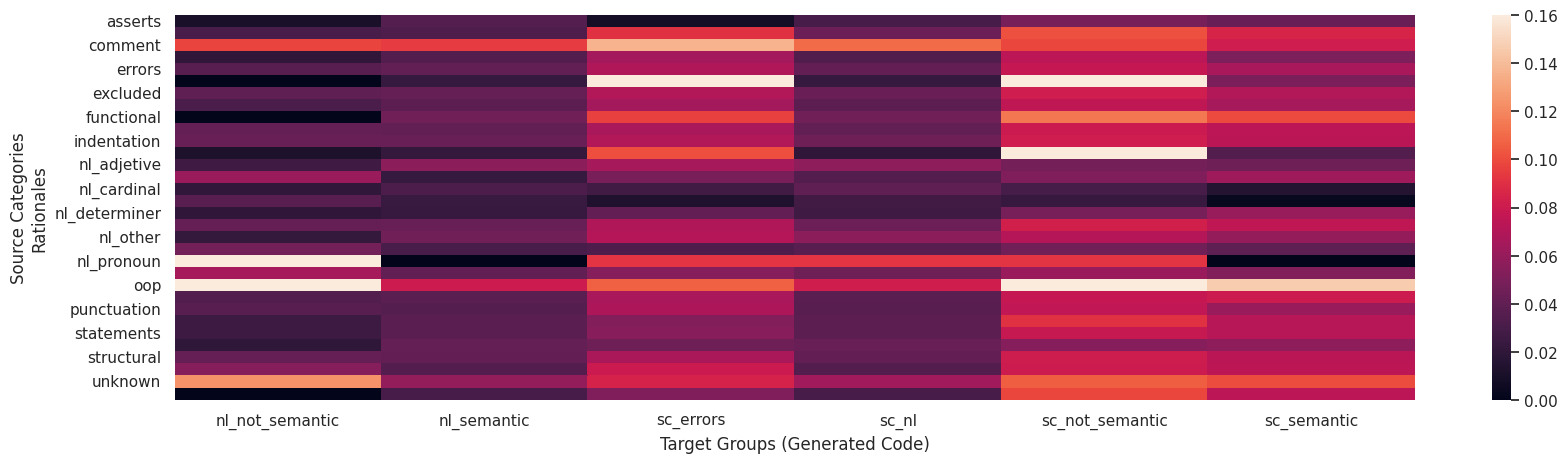

In [37]:
print_heatmap(rationales_results, xlabel='Target Groups (Generated Code)', ylabel='Source Categories\nRationales', fig_size=(5,15), vmax=0.16)

### Prototyping results
The following subsections show the generated *level_1_2* heatmaps for all the four datasets, in the two modalitites. 
To generate the plots from scrach, please modify the following parameters in ```param_default``` at the beginning of the notebook and run the notebook until this point. 
- ```'model'```
- ```'dataset'```
- ```'modality'```

### Results
- There is a dependency between non-semantic elements in the source code and [oop], [loops], and [exceptions] across all four datasets. This pattern is likely explained by the grammar rules of the programming language, which indicate the use of indentation tokens, punctuation, and other non-semantic elements when defining any type of structure.


#### Modality SC
![level_1_2.png](captures/heatmaps/nl_sc/level_1_2.jpg)

#### Modality NL_SC
![level_1_2.png](captures/heatmaps/sc/level_1_2.jpg)